In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [54]:
df = pd.read_csv('insurance.csv')

In [55]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# No missing Values

df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [57]:
y = df['charges']
X = df.iloc[:,:-1]

In [59]:
# Encoding categorical features and scaling

categorical_cols = list(set(X.columns) - set(X._get_numeric_data().columns))
X = pd.get_dummies(X, columns=categorical_cols,drop_first=True)


from sklearn.preprocessing import StandardScaler

sca = StandardScaler().set_output(transform='pandas')

X = sca.fit_transform(X)


# Splitting into 80/10/10 for train, validation, and test respectivly

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)

models = {}



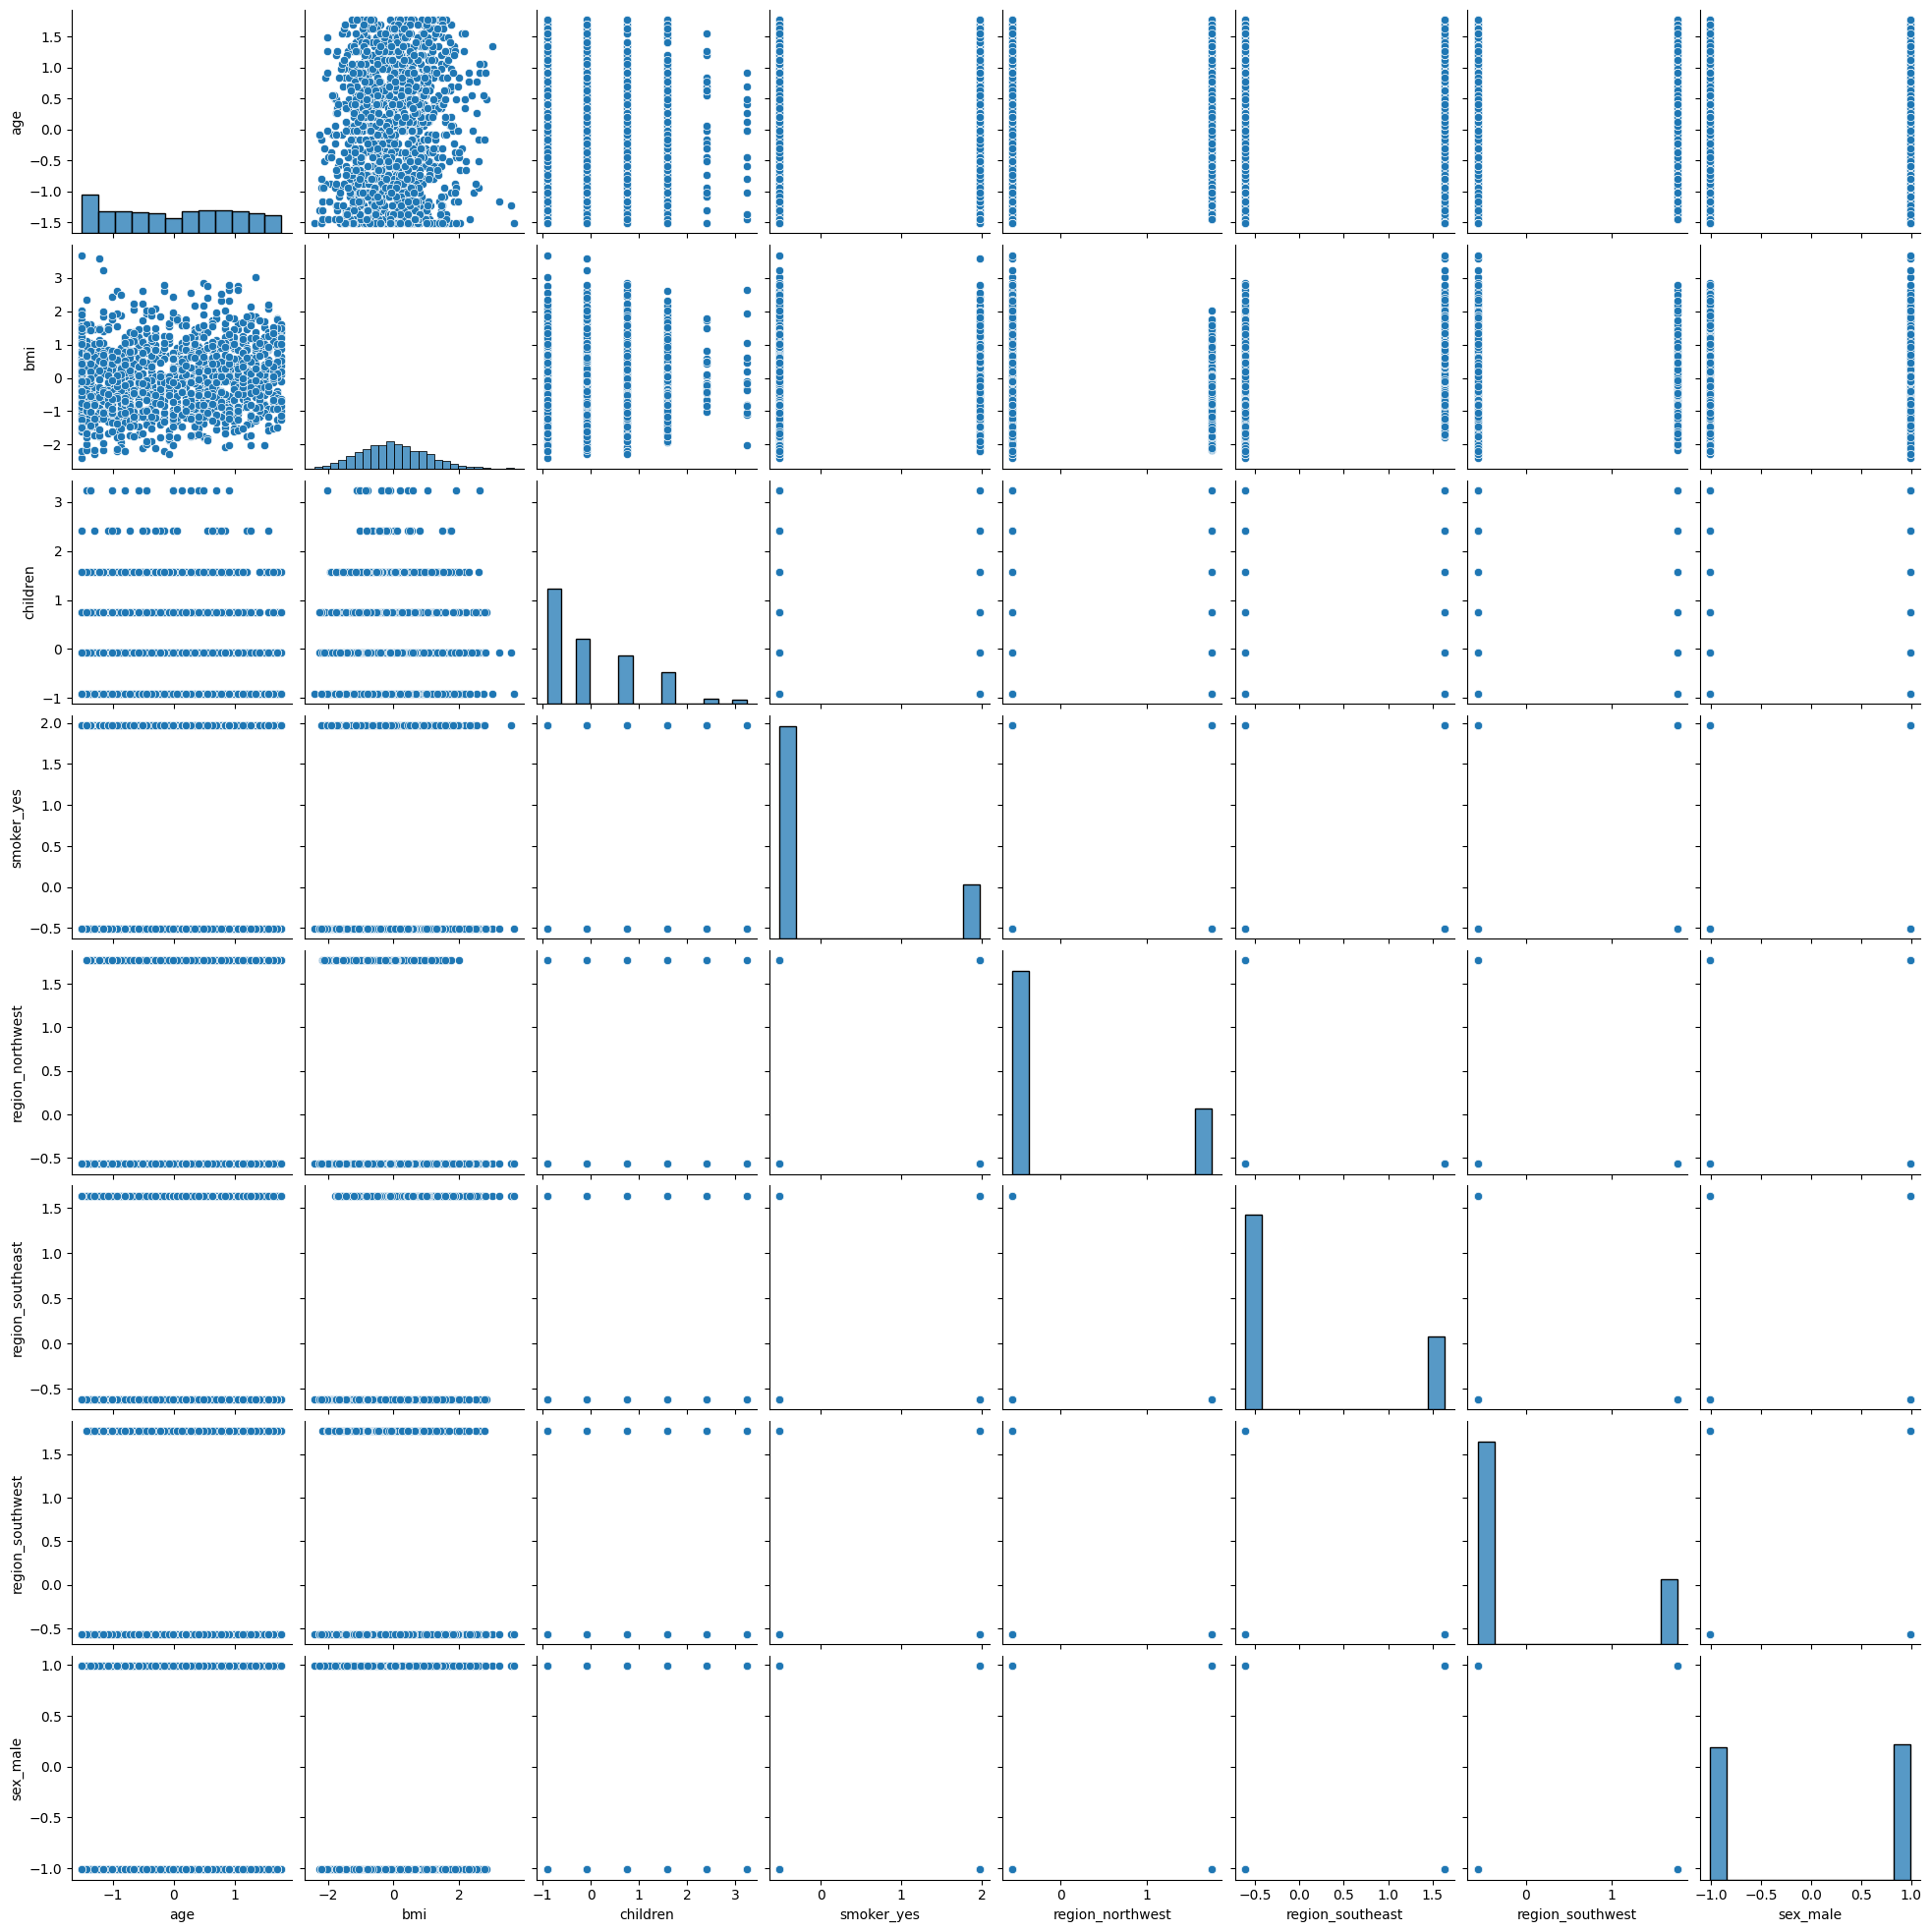

In [48]:
# pairplots
sns.pairplot(X)
plt.show()

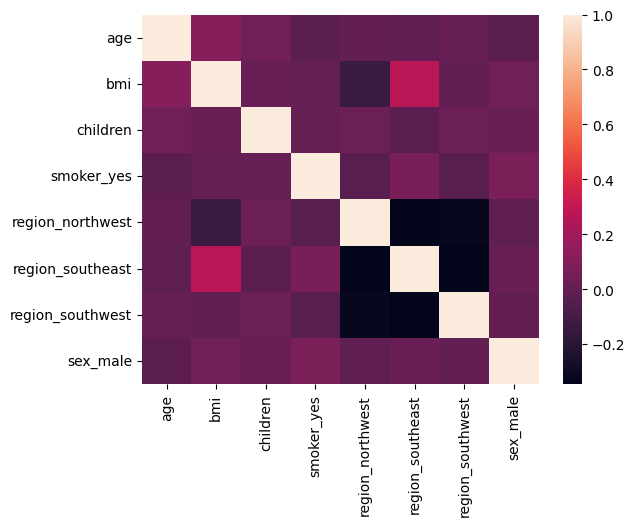

In [49]:
# correlation heatmap
corr = X.corr()

sns.heatmap(corr)
plt.show()

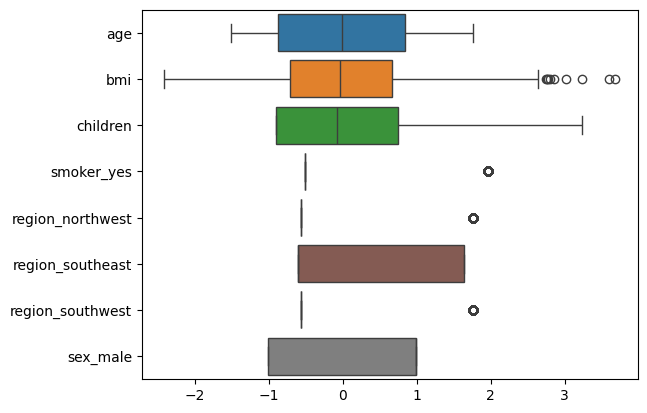

In [50]:
# boxplots
sns.boxplot(X,orient='h')
plt.show()

Looking at the pair plots and correlation heatmap, there does not appear to be any major collinearity present. Looking at the box plots, the features seem mostly balanced except for the number of children.

In [61]:
import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Optuna tuning for Decision Tree model

def objective(trial):
    params = {
    "criterion": trial.suggest_categorical("criterion", ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    "max_depth": trial.suggest_int("max_depth", 1, 15),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
    "random_state": 50,
    }

    model = DecisionTreeRegressor(**params)
    model.fit(X_train, y_train)
    y_predv = model.predict(X_valid)
    score= r2_score(y_valid, y_predv)
    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


best_criterion = study.best_params["criterion"]
best_max_depth = study.best_params["max_depth"]
min_samples_split = study.best_params["min_samples_split"]
min_samples_leaf = study.best_params["min_samples_leaf"]
random_state = 50

model = DecisionTreeRegressor(criterion=best_criterion, 
                               max_depth=best_max_depth, min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,random_state=random_state)

model.fit(pd.concat([X_train,X_valid], axis=0),pd.concat([y_train,y_valid]))

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

print('Decision Tree R-Squared: ',r2)
print('Decision Tree MSE: ',MSE)
print('Decision Tree MAE: ',MAE)

models['Tree'] = (model, r2, MSE, MAE)

[I 2025-01-06 11:45:57,966] A new study created in memory with name: no-name-f1c7a6d7-4ca9-4c53-aba9-1281442bb046
[I 2025-01-06 11:45:58,009] Trial 0 finished with value: 0.7588203361729434 and parameters: {'criterion': 'poisson', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7588203361729434.
[I 2025-01-06 11:45:58,012] Trial 1 finished with value: 0.755687769203639 and parameters: {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.7588203361729434.
[I 2025-01-06 11:45:58,015] Trial 2 finished with value: 0.7550576419672324 and parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7588203361729434.
[I 2025-01-06 11:45:58,018] Trial 3 finished with value: 0.7547575884726011 and parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8}.

Decision Tree R-Squared:  0.8245231009914686
Decision Tree MSE:  23713964.701221388
Decision Tree MAE:  2342.2843802448524


In [ ]:
# Optuna tuning for Random Forest Model

def objective(trial):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 10, 250, step = 10),
    "criterion": trial.suggest_categorical("criterion", ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    "max_depth": trial.suggest_int("max_depth", 1, 15),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
    "random_state": 50,
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_predv = model.predict(X_valid)
    score= r2_score(y_valid, y_predv)
    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_estimators = study.best_params["n_estimators"]
best_criterion = study.best_params["criterion"]
best_max_depth = study.best_params["max_depth"]
min_samples_split = study.best_params["min_samples_split"]
min_samples_leaf = study.best_params["min_samples_leaf"]
random_state = 50

model = RandomForestRegressor(n_estimators=best_estimators, criterion=best_criterion, 
                               max_depth=best_max_depth, min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,random_state=random_state)

model.fit(pd.concat([X_train,X_valid], axis=0),pd.concat([y_train,y_valid]))

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

print('Rand Forest R-Squared: ',r2)
print('Rand Forest MSE: ',MSE)
print('Rand Forest MAE: ',MAE)

models['Forest'] = (model, r2, MSE, MAE)

[I 2025-01-06 11:51:05,249] A new study created in memory with name: no-name-0b8509ea-9d1b-4f88-8ffd-82658ae05bc7
[I 2025-01-06 11:51:05,397] Trial 0 finished with value: 0.7693026613267776 and parameters: {'n_estimators': 70, 'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7693026613267776.
[I 2025-01-06 11:51:07,254] Trial 1 finished with value: 0.7472930534241283 and parameters: {'n_estimators': 250, 'criterion': 'absolute_error', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.7693026613267776.
[I 2025-01-06 11:51:07,544] Trial 2 finished with value: 0.7678861226462828 and parameters: {'n_estimators': 230, 'criterion': 'poisson', 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7693026613267776.
[I 2025-01-06 11:51:08,064] Trial 3 finished with value: 0.7510978074033506 and parameters: {'n_estimators': 70, 'criter

Rand Forest R-Squared:  0.8287188993207644
Rand Forest MSE:  23146944.11881683
Rand Forest MAE:  2358.714138775283


In [ ]:
# Optuna tuning for SVR model

def objective(trial):
    params = {
    "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
    "degree": trial.suggest_int("degree", 1, 6),
    "C": trial.suggest_float("C", 0.01, 3),
    "epsilon": trial.suggest_float("epsilon", 0.01, 2),
    }

    model = SVR(**params)
    model.fit(X_train, y_train)
    y_predv = model.predict(X_valid)
    score= r2_score(y_valid, y_predv)
    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

best_kernel = study.best_params["kernel"]
best_degree = study.best_params["degree"]
best_C = study.best_params["C"]
best_epsilon = study.best_params["epsilon"]


model = SVR(kernel=best_kernel, degree=best_degree, C=best_C, epsilon=best_epsilon)

model.fit(pd.concat([X_train,X_valid], axis=0),pd.concat([y_train,y_valid]))

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

print('SVR R-Squared: ',r2)
print('SVR MSE: ',MSE)
print('SVR MAE: ',MAE)

models['SVR'] = (model, r2, MSE, MAE)

[I 2025-01-06 11:59:34,652] A new study created in memory with name: no-name-2f280f28-2739-4082-90c0-6ea466169603
[I 2025-01-06 11:59:34,706] Trial 0 finished with value: -0.061934756220055176 and parameters: {'kernel': 'sigmoid', 'degree': 4, 'C': 0.764345980944211, 'epsilon': 1.4335155700723345}. Best is trial 0 with value: -0.061934756220055176.
[I 2025-01-06 11:59:34,727] Trial 1 finished with value: -0.010416601243497414 and parameters: {'kernel': 'linear', 'degree': 2, 'C': 0.6174840658401695, 'epsilon': 0.6210526690157401}. Best is trial 1 with value: -0.010416601243497414.
[I 2025-01-06 11:59:34,757] Trial 2 finished with value: -0.05303090418173717 and parameters: {'kernel': 'sigmoid', 'degree': 4, 'C': 1.6004078977472942, 'epsilon': 1.2641653586339636}. Best is trial 1 with value: -0.010416601243497414.
[I 2025-01-06 11:59:34,776] Trial 3 finished with value: -0.06827773729567821 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 0.4549275492230887, 'epsilon': 0.53160471970

SVR R-Squared:  0.23083509378690892
SVR MSE:  103945018.05316672
SVR MAE:  5308.973621046445


Comparing the 3 tuned and trained models, we see the best R-Squared scores and lowest MSE in the Random Forest model, slightly behind in both these metrics is the Decision tree model, then the SVR model is the worst performing with a much lower R-Squared.

In [91]:
# Storing the models and frames to pickles for future use.

def export_to_pickle(models_dict,X_train, X_test, y_train, y_test, X, y):
    import pickle
    path = 'insurance_models'
    for key in models_dict.keys():
        pickle.dump(models_dict[key][0], open('insurance_models/'+key+'.pkl', 'wb'))

    dfs = [X_train, X_test, y_train, y_test, X, y]
    pickle.dump(dfs, open('insurance_models/dataframes.pkl', 'wb'))



export_to_pickle(models, pd.concat([X_train, X_valid], axis=0), X_test, pd.concat([y_train, y_valid]), y_test, X, y)

In [90]:
models

{'Tree': (DecisionTreeRegressor(criterion='poisson', max_depth=6, min_samples_leaf=3,
                        min_samples_split=12, random_state=50),
  0.8245231009914686,
  np.float64(23713964.701221388),
  np.float64(2342.2843802448524)),
 'Forest': (RandomForestRegressor(criterion='friedman_mse', max_depth=9, min_samples_leaf=3,
                        min_samples_split=5, n_estimators=60, random_state=50),
  0.8287188993207644,
  np.float64(23146944.11881683),
  np.float64(2358.714138775283)),
 'SVR': (SVR(C=2.9999352800301153, degree=6, epsilon=1.2329475993748185, kernel='linear'),
  0.23083509378690892,
  np.float64(103945018.05316672),
  np.float64(5308.973621046445))}